## Introduction <a name="introduction"></a>

**A model to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination. The solution will help Sendy enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.**

# Table of contents
1. [Introduction](#introduction)
2. [Importing libraries](#Importing_libraries)
3. [Importing datasets](#Importing_datasets)
4. [A quick look at how our data is structured](#Data_structure)
5. [Data Visualization](#visuals)
    1. [Temperature distribution](#temperature)
    2. [Vehicle types](#vehicle_types)
    3. [Platform types](#platform_types)
    4. [Personal or Business](#personal_or_business)
    5. [Order placement](#order_placement)
        1. [Order placement day of the month](#order_placement_day_of_the_month)
        2. [Placement weekday](#placement_weekday)
    6. [Order confirmation](#order_confirmation)
        1. [Confirmation day of month](#confirmation_day_of_month)
        2. [Confirmation weekday](#confirmation_weekday)
6. [Data Preprocessing](#data_preprocessing)
7. [Modeling](#modeling)
    1. [Linear Regression Model](#linear_model)
    2. [XGBoost](#xgb)
    3. [Random Forest](#random_forest)
    4. [Decision Tree](#decision_tree)
8. [Conclusion](#conclusion)

# Importing libraries <a name="Importing_libraries"></a>

In [1]:
!pip3 install category_encoders
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xgb
import category_encoders as ce
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta
from scipy.stats import uniform, randint 
import pickle

     |████████████████████████████████| 81kB 3.2MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importing datasets <a name="Importing_datasets"></a>

In [0]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
riders = pd.read_csv("Riders.csv")
sample_submission = pd.read_csv("SampleSubmission.csv")
variable_definitions = pd.read_csv("VariableDefinitions.csv")

# A quick look at how our data is structured <a name="Data_structure">

### Variable definitions

In [3]:
display(variable_definitions)

,Order No,Unique number identifying the order
0,User Id,Unique number identifying the customer on a pl...
1,Vehicle Type,"For this competition limited to bikes, however..."
2,Platform Type,"Platform used to place the order, there are 4 ..."
3,Personal or Business,Customer type
4,Placement - Day of Month,Placement - Day of Month i.e 1-31
5,Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
6,Placement - Time,Placement - Time - Time of day the order was p...
7,Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
8,Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)
9,Confirmation - Time,Confirmation - Time - Time of day the order wa...


### Train data

In [4]:
print(f"The training dataset has {train.shape[0]} rows and {train.shape[1]} columns.") # Getting the total number of rows & columns in the training data.
display(train.info())
display(train.head()) # The 1st 5 rows.
display(train.describe())

The training dataset has 21201 rows and 29 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)           

None

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,23.258889,7.905797,-1.281470,36.811264,-1.282581,36.811220,1556.920947
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.615768,17.089971,0.030507,0.037473,0.034824,0.044721,987.270788
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,0.100000,-1.438302,36.653621,-1.430298,36.606594,1.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.075000,-1.300921,36.784605,-1.301201,36.785661,882.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,2.900000,-1.279395,36.807040,-1.284382,36.808002,1369.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,26.000000,4.900000,-1.257147,36.829741,-1.261177,36.829477,2040.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,99.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000


### Test data

In [5]:
print(f"The training dataset has {test.shape[0]} rows and {test.shape[1]} columns.") # Getting the total number of rows & columns in the training data.
display(test.info())
display(test.head()) # The 1st 5 rows.
display(test.describe())

The training dataset has 7068 rows and 25 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time              

None

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
count,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,5631.000000,199.000000,7068.000000,7068.000000,7068.000000,7068.000000
mean,2.752122,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,9.458970,23.246120,6.651759,-1.282043,36.811148,-1.282255,36.811326
std,0.624000,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,5.575689,3.591161,14.085439,0.030044,0.037962,0.034236,0.043507
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.200000,0.100000,-1.433512,36.653828,-1.422652,36.639195
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.100000,-1.301201,36.784605,-1.300921,36.786546
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.400000,2.900000,-1.281301,36.807219,-1.283219,36.807927
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,25.900000,4.950000,-1.257274,36.829716,-1.261256,36.828195
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,47.000000,32.100000,99.100000,-1.148352,36.991046,-1.030225,37.018958


# Data Visualization <a name="visuals">

### Temperature distribution <a name="temperature">

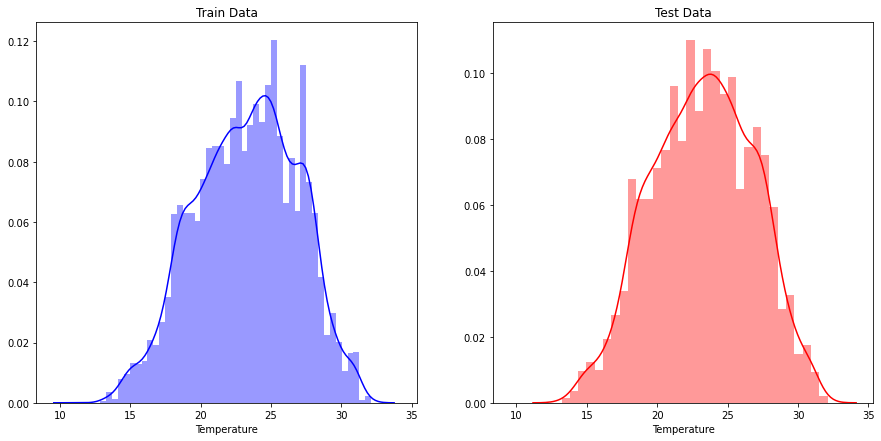

In [6]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train Data")
axes[1].set_title("Test Data")
sns.distplot(train["Temperature"], color="blue", ax=axes[0])
sns.distplot(test["Temperature"], color="red", ax=axes[1])

In [7]:
print("Train mean {}".format(train["Temperature"].mean()))
print("Train median {}".format(train["Temperature"].median()))
print("Test mean {}".format(test["Temperature"].mean()))
print("Test median {}".format(test["Temperature"].median()))

Train mean 23.25888921888938
Train median 23.5
Test mean 23.246119694548046
Test median 23.4


The mean and median temperature values are pretty much the same, we can safely use either 1 to replace the missing temperature values in our data.

In [0]:
clean_train_df = train.copy(deep=True)
clean_test_df = test.copy(deep=True)
clean_train_df["Temperature"].fillna(clean_train_df["Temperature"].mean(), inplace=True)
clean_test_df["Temperature"].fillna(clean_test_df["Temperature"].mean(), inplace=True)

replacing missing temperature values with the mean temperature.

### Vehicle types <a name="vehicle_types">

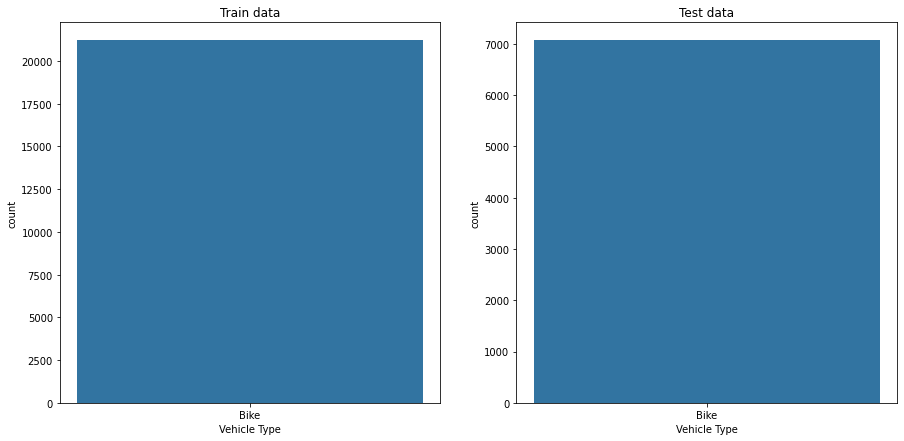

In [9]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train data")
axes[1].set_title("Test data")
sns.countplot(x='Vehicle Type', data=train, ax=axes[0])
sns.countplot(x='Vehicle Type', data=test, ax=axes[1])

from the **count plot** above we can see that there's only **one** vehicle type, so we can safely discard this column

### Platform types <a name="platform_types">

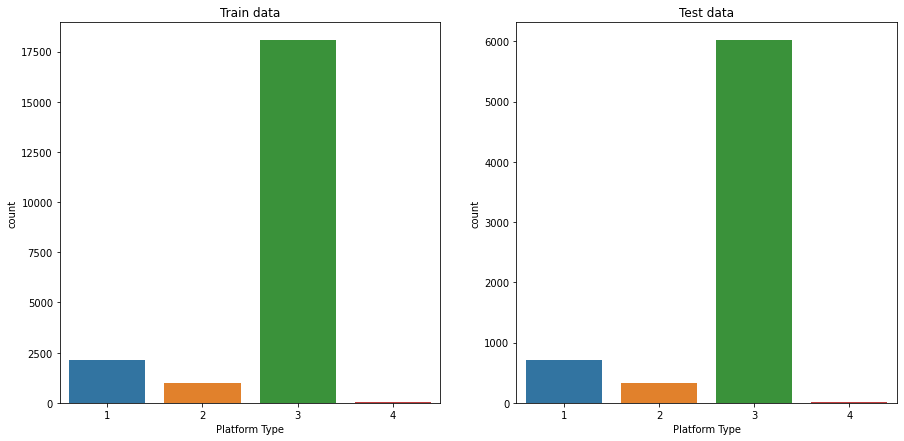

In [10]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train data")
axes[1].set_title("Test data")
sns.countplot(x='Platform Type', data=train, ax=axes[0])
sns.countplot(x='Platform Type', data=test, ax=axes[1])

We have **four** different vehicle **platform types** which makes this feature very usefull as vehicle perfomance may vary drastically based on the platform type.

### Personal or business <a name="personal_or_business">

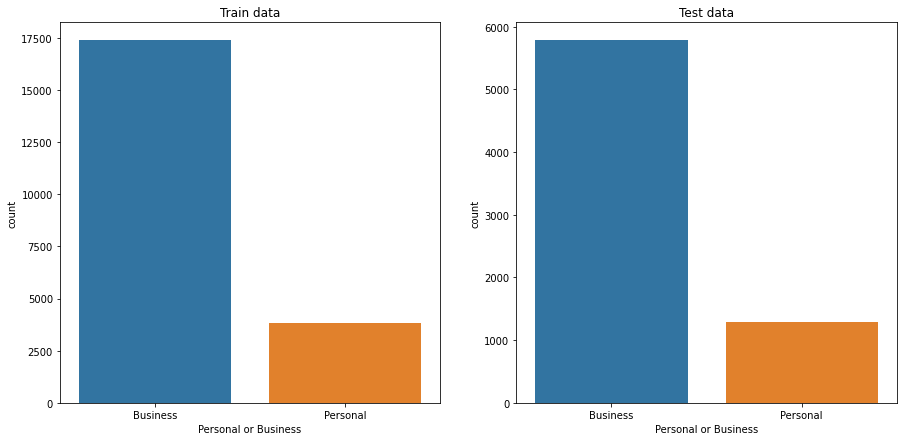

In [11]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train data")
axes[1].set_title("Test data")
sns.countplot(x='Personal or Business', data=train, ax=axes[0])
sns.countplot(x='Personal or Business', data=test, ax=axes[1])

There is a possibility that when you are delivering to a **Business** you will be more effecient than when you are delivering to an individual because business always goes for the most effecient supplier, they can always drop you.

### Order Placement <a name="order_placement">

#### Order placement day of the month <a name="order_placement_day_of_the_month">

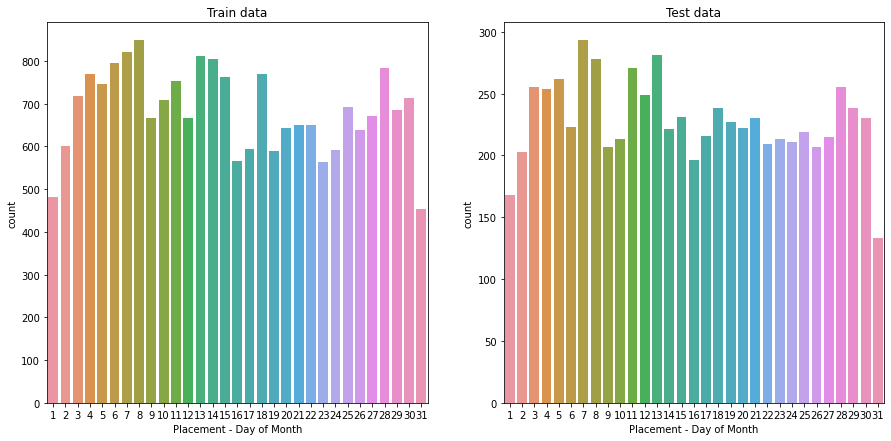

In [12]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train data")
axes[1].set_title("Test data")
sns.countplot(x='Placement - Day of Month', data=train, ax=axes[0])
sns.countplot(x='Placement - Day of Month', data=test, ax=axes[1])

#### Placement - Weekday (Mo = 1) <a name="placement_weekday">

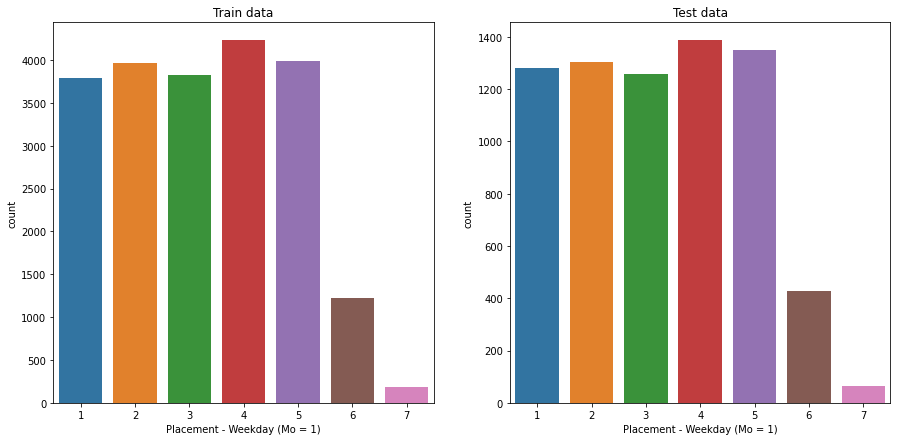

In [13]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train data")
axes[1].set_title("Test data")
sns.countplot(x='Placement - Weekday (Mo = 1)', data=train, ax=axes[0])
sns.countplot(x='Placement - Weekday (Mo = 1)', data=test, ax=axes[1])

### Order Confirmation <a name="order_confirmation">

#### Confirmation - Day of Month <a name="confirmation_day_of_month">

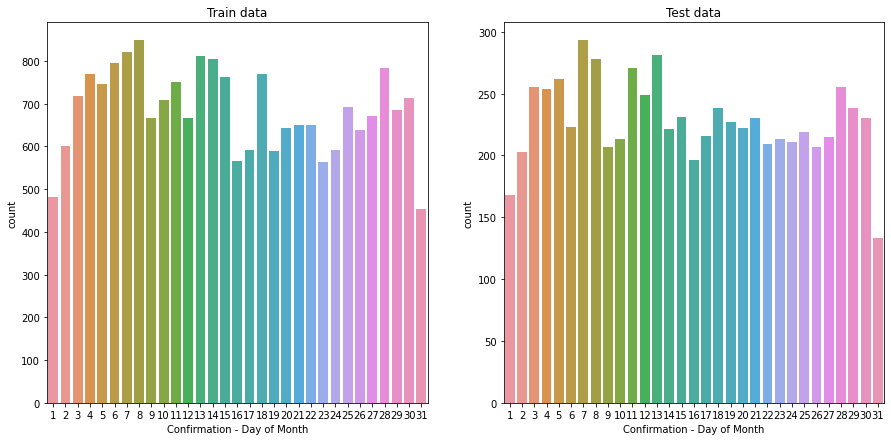

In [14]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train data")
axes[1].set_title("Test data")
sns.countplot(x='Confirmation - Day of Month', data=train, ax=axes[0])
sns.countplot(x='Confirmation - Day of Month', data=test, ax=axes[1])

#### Confirmation - Weekday (Mo = 1) <a name="confirmation_weekday">

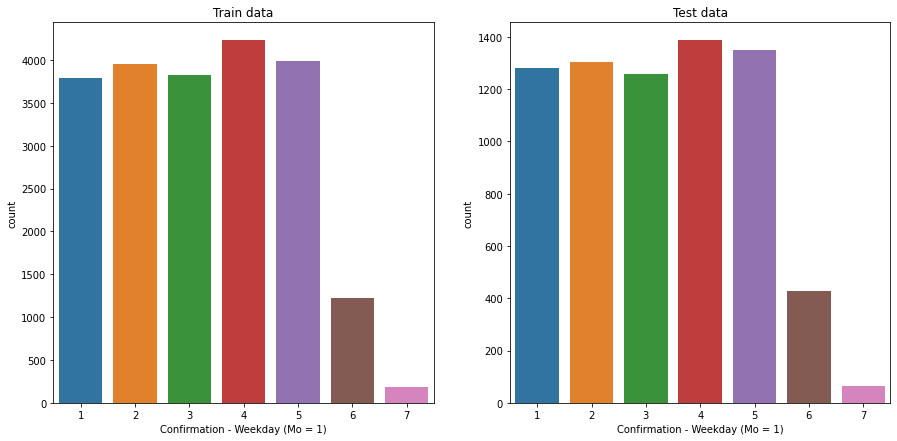

In [15]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train data")
axes[1].set_title("Test data")
sns.countplot(x='Confirmation - Weekday (Mo = 1)', data=train, ax=axes[0])
sns.countplot(x='Confirmation - Weekday (Mo = 1)', data=test, ax=axes[1])

Looking at the 4 count plots we have **above**, we can see that most of the orders get confirmed on the day they were placed. We can safely discard either one of the placement or confimation date data.

In [16]:
clean_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [17]:
clean_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

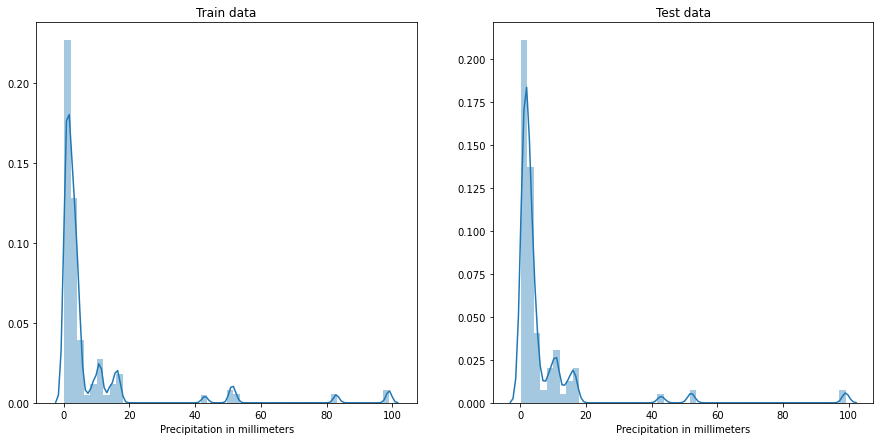

In [18]:
f, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
axes[0].set_title("Train data")
axes[1].set_title("Test data")
sns.distplot(train["Precipitation in millimeters"], ax=axes[0])
sns.distplot(test["Precipitation in millimeters"], ax=axes[1])

In [19]:
clean_train_df["Rainfall"] = clean_train_df["Precipitation in millimeters"]
clean_test_df["Rainfall"] = clean_test_df["Precipitation in millimeters"]
clean_train_df["Rainfall"]. loc[(clean_train_df["Rainfall"] >= 0)] = 1
clean_test_df["Rainfall"]. loc[(clean_test_df["Rainfall"] >= 0)] = 1
clean_train_df["Rainfall"].fillna(0, inplace=True)
clean_test_df["Rainfall"].fillna(0, inplace=True)
display(clean_train_df["Rainfall"].head(30))
display(clean_test_df["Rainfall"].head(30))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    1.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
Name: Rainfall, dtype: float64

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
Name: Rainfall, dtype: float64

Rainfall can have a huge impact on delivery time, so instead of just dropping the precipitation column we'll just assume that there wasn't any rainfall on the days with missing data (this will be represented by a **zero** and the days with rainfall will be represented by a **one**). 

### Data preprocessing <a name='data_preprocessing'>

A function to convert the time features into the number of **seconds after midnight**.

In [0]:
def seconds_after_midnight(input_df):
    df = input_df.copy(deep=True)
    placement_time = []
    confirmation_time = []
    arrival_at_pickup_time = []
    pickup_time = []
    arrival_at_destination_time = []
    for time in df["Placement - Time"]:
        i = 0
        if time[-2:] == "PM":
            i = 12
        split_time = time.split(":")
        placement_time.append(timedelta(hours=int(split_time[0].replace(" ", "")) + i, minutes=int(split_time[1]), seconds=int(split_time[2][:2])).total_seconds())
    for time in df["Confirmation - Time"]:
        i = 0
        if time[-2:] == "PM":
            i = 12
        split_time = time.split(":")
        confirmation_time.append(timedelta(hours=int(split_time[0].replace(" ", "")) + i, minutes=int(split_time[1]), seconds=int(split_time[2][:2])).total_seconds())
    for time in df["Arrival at Pickup - Time"]:
        i = 0
        if time[-2:] == "PM":
            i = 12
        split_time = time.split(":")
        arrival_at_pickup_time.append(timedelta(hours=int(split_time[0].replace(" ", "")) + i, minutes=int(split_time[1]), seconds=int(split_time[2][:2])).total_seconds())
    for time in df["Pickup - Time"]:
        i = 0
        if time[-2:] == "PM":
            i = 12
        split_time = time.split(":")
        pickup_time.append(timedelta(hours=int(split_time[0].replace(" ", "")) + i, minutes=int(split_time[1]), seconds=int(split_time[2][:2])).total_seconds())
    df["placement_time"] = placement_time
    df["confirmation_time"] = confirmation_time
    df["arrival_at_pickup_time"] = arrival_at_pickup_time
    df["pickup_time"] = pickup_time
    return df



A fuction for some data preprocessing.

In [0]:
def data_preprocessing(df):
    duplicate_df = df.copy(deep=True)
    duplicate_df["Temperature"].fillna(round(duplicate_df["Temperature"].mean(), 0), inplace=True)
    columns_to_drop = ["Vehicle Type",
                       "Placement - Time", "Confirmation - Day of Month",
                       "Confirmation - Weekday (Mo = 1)", "Confirmation - Time",
                       "Arrival at Pickup - Day of Month", "Arrival at Pickup - Weekday (Mo = 1)",
                       "Arrival at Pickup - Time", "Pickup - Time",
                       "Pickup Lat", "Pickup Long", "Destination Lat", "Destination Long", "Rider Id",
                       "Order No", "User Id"]
    duplicate_df["Personal or Business"] = duplicate_df["Personal or Business"].replace(["Personal"], 0)
    duplicate_df["Personal or Business"] = duplicate_df["Personal or Business"].replace(["Business"], 1)
    duplicate_df.drop(columns_to_drop, axis=1, inplace=True)
    return duplicate_df

In [22]:
clean_train_df.drop("Precipitation in millimeters", axis=1, inplace=True)
clean_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [23]:
clean_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

Converting the data contained in the **Personal or Business** column into a binary format. (0s & 1s).

In [24]:
clean_train_df['Personal or Business'].loc[(clean_train_df['Personal or Business'] == 'Business')] = 1
clean_train_df['Personal or Business'].loc[(clean_train_df['Personal or Business'] == 'Personal')] = 0
clean_test_df['Personal or Business'].loc[(clean_test_df['Personal or Business'] == 'Business')] = 1
clean_test_df['Personal or Business'].loc[(clean_test_df['Personal or Business'] == 'Personal')] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Extracting the order numbers from our test dataset. (This will be used when creating our submission CSV)

In [25]:
Order_No = np.array(clean_test_df["Order No"].tolist())
Order_No.shape

(7068,)

In [26]:
clean_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [27]:
clean_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

# Modeling <a name='modeling'>

data cleanup.

In [28]:
clean_train = data_preprocessing(seconds_after_midnight(clean_train_df))
clean_test = data_preprocessing(seconds_after_midnight(clean_test_df))
display(clean_train.info())
display(clean_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Platform Type                              21201 non-null  int64  
 1   Personal or Business                       21201 non-null  object 
 2   Placement - Day of Month                   21201 non-null  int64  
 3   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 4   Pickup - Day of Month                      21201 non-null  int64  
 5   Pickup - Weekday (Mo = 1)                  21201 non-null  int64  
 6   Arrival at Destination - Day of Month      21201 non-null  int64  
 7   Arrival at Destination - Weekday (Mo = 1)  21201 non-null  int64  
 8   Arrival at Destination - Time              21201 non-null  object 
 9   Distance (KM)                              21201 non-null  int64  
 10  Temperature           

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Platform Type                 7068 non-null   int64  
 1   Personal or Business          7068 non-null   object 
 2   Placement - Day of Month      7068 non-null   int64  
 3   Placement - Weekday (Mo = 1)  7068 non-null   int64  
 4   Pickup - Day of Month         7068 non-null   int64  
 5   Pickup - Weekday (Mo = 1)     7068 non-null   int64  
 6   Distance (KM)                 7068 non-null   int64  
 7   Temperature                   7068 non-null   float64
 8   Precipitation in millimeters  199 non-null    float64
 9   Rainfall                      7068 non-null   float64
 10  placement_time                7068 non-null   float64
 11  confirmation_time             7068 non-null   float64
 12  arrival_at_pickup_time        7068 non-null   float64
 13  pic

None

In [29]:
y = clean_train['Time from Pickup to Arrival'].values
y_df = clean_train['Time from Pickup to Arrival']
clean_train.drop(['Time from Pickup to Arrival', 'Arrival at Destination - Time',
                  'confirmation_time', 'arrival_at_pickup_time',
                 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Day of Month', 'Rainfall'], axis=1, inplace=True)
#x_df["Rainfall"] = clean_train_df["Rainfall"]
x = clean_train.iloc[:, :].values

display(x)
display(y)

array([[3, 1, 9, ..., 20.4, 34546.0, 37650.0],
       [3, 0, 12, ..., 26.4, 40576.0, 42249.0],
       [3, 1, 30, ..., 23.25888921888938, 88765.0, 89583.0],
       ...,
       [3, 1, 7, ..., 29.2, 61576.0, 64252.0],
       [1, 0, 4, ..., 15.0, 34299.0, 35115.0],
       [3, 1, 26, ..., 30.9, 51587.0, 52915.0]], dtype=object)

array([ 745, 1993,  455, ..., 2953, 1380, 2128])

In [0]:
clean_test.drop(['Precipitation in millimeters', 'Rainfall', 'confirmation_time', 'arrival_at_pickup_time'], axis=1, inplace=True)

In [31]:
display(clean_train.info())
display(clean_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Platform Type                 21201 non-null  int64  
 1   Personal or Business          21201 non-null  object 
 2   Placement - Day of Month      21201 non-null  int64  
 3   Placement - Weekday (Mo = 1)  21201 non-null  int64  
 4   Pickup - Day of Month         21201 non-null  int64  
 5   Pickup - Weekday (Mo = 1)     21201 non-null  int64  
 6   Distance (KM)                 21201 non-null  int64  
 7   Temperature                   21201 non-null  float64
 8   placement_time                21201 non-null  float64
 9   pickup_time                   21201 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 1.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Platform Type                 7068 non-null   int64  
 1   Personal or Business          7068 non-null   object 
 2   Placement - Day of Month      7068 non-null   int64  
 3   Placement - Weekday (Mo = 1)  7068 non-null   int64  
 4   Pickup - Day of Month         7068 non-null   int64  
 5   Pickup - Weekday (Mo = 1)     7068 non-null   int64  
 6   Distance (KM)                 7068 non-null   int64  
 7   Temperature                   7068 non-null   float64
 8   placement_time                7068 non-null   float64
 9   pickup_time                   7068 non-null   float64
dtypes: float64(3), int64(6), object(1)
memory usage: 552.3+ KB


None

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_test

array([ 992, 2400, 3486, ...,  173, 1844,   25])

###The heatmap

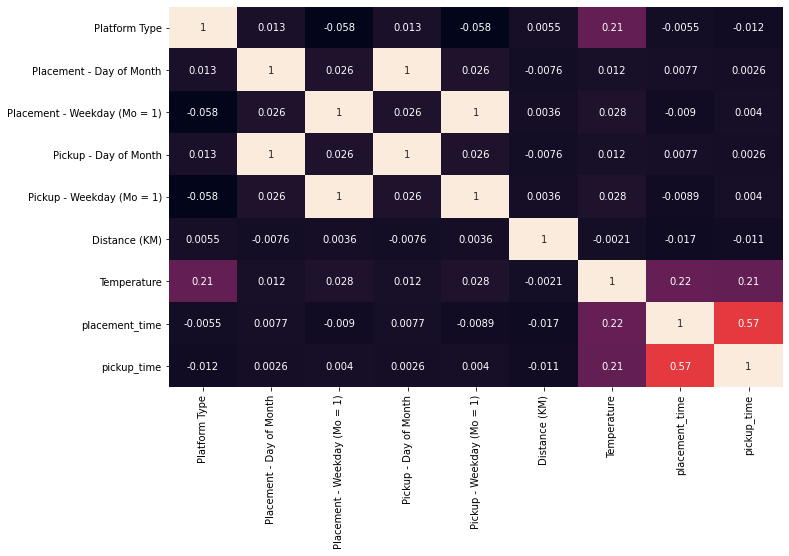

In [33]:
plt.figure(figsize=(11, 7))
corr = clean_train.corr()
sns.heatmap(corr, annot=True, cbar=False)



The heatmap displays **correlation** on the red colour between **placement_time** and **pickup_time**. The other points that are displayed are significally lower therefore they display no correlation, we say this because they are lower than 0.3.

where they are at 1 points are displayed diagonal which simply means a point cannot be correlated against itself.

Categorical data encoding.

In [34]:
ce_one_hot = ce.OneHotEncoder(cols=["Platform Type", "Personal or Business"])
x_train_data = ce_one_hot.fit_transform(clean_train.iloc[:, :])
y_train_data = y_df
x_test_data = ce_one_hot.fit_transform(clean_test.iloc[:, :])
x_test_data.shape

(7068, 14)

## Linear Regression Model <a name='linear_model'>

In [35]:
linear_reg = LinearRegression()
linear_reg.fit(x_train_data, y_train_data)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
lin_pred = linear_reg.predict(x_test_data)
sub = np.concatenate((Order_No.reshape(len(Order_No), 1), lin_pred.reshape(len(lin_pred), 1)), 1)
submission_df = pd.DataFrame()
submission_df["Order_No"] = Order_No
submission_df["Time from Pickup to Arrival"] = lin_pred
submission_df.head()
submission_df.to_csv('submission_linear_reg.csv', index=False)

## XGBoost <a name='xgb'>

In [37]:
xgb_model = xgb.XGBRegressor()
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 200), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)
search.fit(x_train_data, y_train_data)
#pred = search.predict(x_test)
#np.set_printoptions(precision=2)
#print(np.concatenate((pred.reshape(len(pred), 1), y_test.reshape(len(y_test), 1)), 1))

#rms = sqrt(mean_squared_error(y_test, pred))
#rms

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[06:53:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[06:53:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 14.2min finished


[07:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f04ac375550>,
                                        'max_depth': <scipy

In [0]:
xgb_model_prediction = search.predict(x_test_data)
sub = np.concatenate((Order_No.reshape(len(Order_No), 1), xgb_model_prediction.reshape(len(xgb_model_prediction), 1)), 1)
submission_df = pd.DataFrame()
submission_df["Order_No"] = Order_No
submission_df["Time from Pickup to Arrival"] = xgb_model_prediction
submission_df.head()
submission_df.to_csv('submission_xgb_regressor.csv', index=False)

#saving the model to a pickle file
model_save_path = "xgb_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(search,file)

## Random Forest <a name='random_forest'>

In [39]:
random_forest_regressor = RandomForestRegressor(n_estimators=100, max_depth=5)
random_forest_regressor.fit(x_train, y_train)
random_forest_pred = random_forest_regressor.predict(x_test)
print(np.concatenate((random_forest_pred.reshape(len(random_forest_pred), 1), y_test.reshape(len(y_test), 1)), 1))
sqrt(mean_squared_error(y_test, random_forest_pred))

[[1932.9233834   992.        ]
 [1659.49367139 2400.        ]
 [2301.40861997 3486.        ]
 ...
 [ 827.82813299  173.        ]
 [1871.14428454 1844.        ]
 [1522.37686054   25.        ]]


796.6517216566078

## Decision Tree <a name='decision_tree'>

In [40]:
dtr = DecisionTreeRegressor(max_depth=3)
dtr.fit(x_train, y_train)
yp = dtr.predict(x_test)
np.set_printoptions(precision=2)
print(np.concatenate((yp.reshape(len(yp), 1), y_test.reshape(len(y_test), 1)), 1))

rms = sqrt(mean_squared_error(y_test, yp))
rms

[[1921.44  992.  ]
 [1544.5  2400.  ]
 [2209.61 3486.  ]
 ...
 [ 836.48  173.  ]
 [1921.44 1844.  ]
 [1544.5    25.  ]]


800.1472382439505

# Conclusion <a name='conclusion'>

The XGBoost model was used predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination, this model produced the best results as compared to the Decision Treee and the Random Forest as they had a higher RMS. this model will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.